<a href="https://colab.research.google.com/github/izzahrhnh/Datatada/blob/main/3IS1_GROUP_3_DATATADAA_GROUP_PROJECT_CODE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IS GROUP 3 DATATADAA**
**GROUP MEMBERS**
1. **JASSARAH SYAFIYA BINTI MOHD JALIL**
2. **NUR AMALIN AISYAH BINTI ABD AZIZ**
3. **IZZAH RAIHANAH BINTI REDZUAN**
4. **AZZA ASHRAF WAJDE BIN AZAMAN**



## Data obtained from MPHOnline Bestsellers:
##2024: https://mphonline.com/collections/mph-best-of-2024
##2023: https://mphonline.com/collections/best-of-2024
##Total Data 148 (Links are correct, best-of-2024 is 2023)
Use API obtained from website

#**EXTRACTING DATA ATTRIBUTES (EXTRACT)**

In [164]:
import requests
import json
import math
import pandas as pd
from bs4 import BeautifulSoup
import time # Import time for adding a small delay between requests

def scrape_collection(collection_scope):
    """
    Scrapes all product pages for a given collection_scope ID.
    Returns a pandas DataFrame of the extracted data.
    """
    base_url = "https://services.mybcapps.com/bc-sf-filter/filter"

    headers = {
        # Using essential headers
        "accept": "*/*",
        "accept-language": "en-US,en;q=0.9",
        "referrer": "https://mphonline.com/"
    }

    # Initial parameters for the first request
    params = {
        'shop': 'mph-online.myshopify.com',
        'page': '1',
        'limit': '72', # Products per page
        'sort': 'manual',
        'locale': 'en',
        'event_type': 'collection',
        'build_filter_tree': 'true',
        'sid': '25d63419-2baa-469e-876d-f377687a3135',
        'collection_scope': collection_scope
    }

    all_books_data = [] # List to store dictionaries of book data

    print(f"\n--- Starting scrape for Collection ID: {collection_scope} ---")

    try:
        #Get total product count from the first page request
        response = requests.get(base_url, headers=headers, params=params)
        response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
        data = response.json()
        total_products = data.get("total_product", 0)

        if total_products == 0:
            print("No products found for this collection. Skipping.")
            return pd.DataFrame()

        limit = int(params['limit'])
        total_pages = math.ceil(total_products / limit)
        print(f"Total products found: {total_products}. Scraping {total_pages} pages.")

        #Iterate through all required pages
        for page in range(1, total_pages + 1):
            print(f"-> Scraping page {page}/{total_pages}")
            params['page'] = str(page)

            #Make the request for the current page
            response = requests.get(base_url, headers=headers, params=params)
            response.raise_for_status()

            page_data = response.json()
            products_on_page = page_data.get("products", [])

            if not products_on_page:
                print("No products returned on this page. Stopping page loop.")
                break

            #Extract data from each product
            for product in products_on_page:

                #Extract Metafields (Format, Date)
                metafields = product.get('metafields', [])
                format_value = next((item['value'] for item in metafields if item['key'] == 'format'), 'N/A')
                date_published = next((item['value'] for item in metafields if item['key'] == 'datepublished'), 'N/A')

                #Extract ISBN / Barcode from the first variant
                variants = product.get('variants', [])
                isbn = variants[0].get('barcode', 'N/A') if variants else 'N/A'

                #Extract Genres from Tags
                tags = product.get('tags', [])
                original_tags = product.get('original_tags', [])
                all_tags = list(set(tags + original_tags))
                genres = []
                for tag in all_tags:
                    #Filter tags that represent product classification/genre
                    if tag.startswith('Class_'):
                        genres.append(tag.replace('Class_', '').strip())
                    elif tag.startswith('Subclass_'):
                        genres.append(tag.replace('Subclass_', '').strip())

                # --- BUILD DICTIONARY ---
                book_entry = {
                    'Title': product.get('title'),
                    'Author': product.get('product_type'),
                    'Vendor': product.get('vendor'),
                    'ISBN': isbn,
                    'Best Selling Rank': product.get('best_selling_rank'),
                    'Price': product.get('price_min'),
                    'Format': format_value,
                    'Date Published': date_published,
                    'Genres': ', '.join(genres) if genres else 'N/A'
                }

                all_books_data.append(book_entry)

            #Add a small delay to be polite to the server
            time.sleep(0.5)

        print(f"Scraping for {collection_scope} complete. Collected {len(all_books_data)} items.")

        #Create and return DataFrame
        return pd.DataFrame(all_books_data)

    except requests.exceptions.HTTPError as e:
        print(f"HTTP Error during scrape for {collection_scope}: {e}. Skipping.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred during scrape for {collection_scope}: {e}. Skipping.")
        return pd.DataFrame()

def run_scraper(collection_scopes):
    all_dfs = []

    for scope in collection_scopes:
        df = scrape_collection(scope)
        if not df.empty:
            all_dfs.append(df)

    if not all_dfs:
        print("\nNo data collected from any specified collections.")
        return pd.DataFrame()

    # Use pandas.concat to combine all collected DataFrames
    final_df = pd.concat(all_dfs, ignore_index=True)

    print("\n=======================================================")
    print(f"Successfully combined data from {len(all_dfs)} collections.")
    print(f"Total rows in final DataFrame: {len(final_df)}")
    print("=======================================================")

    return final_df

# --- EXECUTION ---
# Define the list of collection scopes to be scraped (2023, 2024 bestsellers)
target_collection_scopes = ['328076132509', '318410457245']

# Run the scraper
final_combined_df = run_scraper(target_collection_scopes)

# Print a summary of the final DataFrame
print(final_combined_df.head())

# Optional: Save to CSV
final_combined_df.to_csv('mph_combined_books_data.csv', index=False)


--- Starting scrape for Collection ID: 328076132509 ---
Total products found: 82. Scraping 2 pages.
-> Scraping page 1/2
-> Scraping page 2/2
Scraping for 328076132509 complete. Collected 82 items.

--- Starting scrape for Collection ID: 318410457245 ---
Total products found: 66. Scraping 1 pages.
-> Scraping page 1/1
Scraping for 318410457245 complete. Collected 66 items.

Successfully combined data from 2 collections.
Total rows in final DataFrame: 148
                                               Title         Author  \
0          Thariq Ridzuwan Commando's : His Treasure      Hudanajwa   
1                   Dog Man #12: The Scarlet Shedder    Pilkey, Dav   
2                                    Shattered Hopes    Bose, Romen   
3  Alfu Sanatin : Garis Masa Dari Khalifah Uthman...     Ibnu Rijal   
4                                   The Siege Within  Lopez, Leslie   

             Vendor           ISBN  Best Selling Rank  Price     Format  \
0      IDEA KREATIF  9789672803386    

In [165]:
final_combined_df.head()

,Title,Author,Vendor,ISBN,Best Selling Rank,Price,Format,Date Published,Genres
0,Thariq Ridzuwan Commando's : His Treasure,Hudanajwa,IDEA KREATIF,9789672803386,13,35.00,Paperback,2023-11-15,"NOVEL, CINTA"
1,Dog Man #12: The Scarlet Shedder,"Pilkey, Dav",Scholastic Press,,832,34.90,Paperback,2025-02-01,N/A
2,Shattered Hopes,"Bose, Romen",PRH SEA,9789815127911,408,79.95,Paperback,2024-06-30,"MALAYSIAN BIOGRAPHIES, MALAYSIAN COLLECTION"
3,Alfu Sanatin : Garis Masa Dari Khalifah Uthman...,Ibnu Rijal,Karya Bestari,9789678610414,267,32.00,Paperback,2024-08-07,"RUJUKAN AGAMA: SEJARAH & POLITIK, RUJUKAN AGAMA"
4,The Siege Within,"Lopez, Leslie",PRH SEA,9789815266313,440,69.95,Paperback,2024-09-24,"MALAYSIAN COLLECTION, MALAYSIAN HISTORY / POLI..."


#**DATA TRANSFORMATION (TRANSFORM)**


a. **DATA PROCESSING**

Data before transformation

In [166]:
import pandas as pd
import numpy as np

#Load dataset
file_path = "mph_combined_books_data.csv"
df = pd.read_csv(file_path)

#Show data types before any transformation
print("Data types before data transformation")
print("--------------------")
print(df.dtypes)
print("\nTotal data")
print("--------------------")
print(df.count())

print("\nEmpty Fields")
print("--------------------")
print(df.isnull().sum())

Data types before data transformation
--------------------
Title                 object
Author                object
Vendor                object
ISBN                 float64
Best Selling Rank      int64
Price                float64
Format                object
Date Published        object
Genres                object
dtype: object

Total data
--------------------
Title                148
Author               148
Vendor               148
ISBN                 126
Best Selling Rank    148
Price                148
Format               147
Date Published       140
Genres               145
dtype: int64

Empty Fields
--------------------
Title                 0
Author                0
Vendor                0
ISBN                 22
Best Selling Rank     0
Price                 0
Format                1
Date Published        8
Genres                3
dtype: int64


**1. Change ISBN from float to string object, handle any missing fields. Change missing ISBN to N/A.**

In [167]:
print("\nFirst 5 ISBNs before conversion")
print("--------------------")
print(df['ISBN'].head())

#Change ISBN to string object
df['ISBN'] = df['ISBN'].astype(str)

#Fix '.0' AND convert 'nan' to 'N/A'
def clean_isbn(x):
    if x == 'nan':
        return 'N/A'
    if x.endswith('.0'):
        return x.split('.')[0]
    return x
df['ISBN'] = df['ISBN'].apply(clean_isbn)

print("\nFirst 5 ISBNs after conversion")
print("--------------------")
print(df['ISBN'].head())



First 5 ISBNs before conversion
--------------------
0    9.789673e+12
1             NaN
2    9.789815e+12
3    9.789679e+12
4    9.789815e+12
Name: ISBN, dtype: float64

First 5 ISBNs after conversion
--------------------
0    9789672803386
1              N/A
2    9789815127911
3    9789678610414
4    9789815266313
Name: ISBN, dtype: object


**2. Clean whitespace and newlines, standardize Title, Author columns.**

In [168]:
#Remove clean whitespace and remove newlines from title, author columns
print("\nFirst 7 Title and Author before conversion")
print("--------------------")
print(df[['Title', 'Author']].head(7))

str_cols = ['Title', 'Author']
for col in str_cols:
    df[col] = df[col].str.replace('\n', ' ', regex=False) # Replace newline with space
    df[col] = df[col].str.strip() # Remove leading whitespaces
    df[col] = df[col].str.title() #Capitalize the 1st letter of every word

print("\nFirst 7 Title and Author after conversion")
print("--------------------")
print(df[['Title', 'Author']].head(7))


First 7 Title and Author before conversion
--------------------
                                               Title         Author
0          Thariq Ridzuwan Commando's : His Treasure      Hudanajwa
1                   Dog Man #12: The Scarlet Shedder    Pilkey, Dav
2                                    Shattered Hopes    Bose, Romen
3  Alfu Sanatin : Garis Masa Dari Khalifah Uthman...     Ibnu Rijal
4                                   The Siege Within  Lopez, Leslie
5  Library of Lost Hearts: An Anthology of Short ...      Nf Afrina
6                      Bayang Sofea by Teme Abdullah  Teme Abdullah

First 7 Title and Author after conversion
--------------------
                                               Title         Author
0          Thariq Ridzuwan Commando'S : His Treasure      Hudanajwa
1                   Dog Man #12: The Scarlet Shedder    Pilkey, Dav
2                                    Shattered Hopes    Bose, Romen
3  Alfu Sanatin : Garis Masa Dari Khalifah Uthman...   

**3. Clean and standardize the 'Genres' column by keeping 'N/A' values intact, stripping extra spaces, correcting capitalization, and removing duplicate genres within each book's genre list.**

In [169]:
print("First 5 Genres before conversion")
print("--------------------")
print(df[['Title', 'Genres']].head())

def clean_genres(genres_str):
    # Handle non-string values
    if not isinstance(genres_str, str):
        return 'N/A'

    if genres_str.strip().upper() == 'N/A' or not genres_str.strip():
        return 'N/A'  # Keep 'N/A' as a placeholder

    # Split, strip, title-case, remove duplicates
    genres_list = [g.strip().title() for g in genres_str.split(',')]
    unique_genres = sorted(list(set([g for g in genres_list if g])))  # remove empty strings

    return ', '.join(unique_genres)

# Apply cleaning
df['Genres'] = df['Genres'].apply(clean_genres)


print("\nFirst 5 Genres after conversion")
print("--------------------")
print(df[['Title', 'Genres']].head())



First 5 Genres before conversion
--------------------
                                               Title  \
0          Thariq Ridzuwan Commando'S : His Treasure   
1                   Dog Man #12: The Scarlet Shedder   
2                                    Shattered Hopes   
3  Alfu Sanatin : Garis Masa Dari Khalifah Uthman...   
4                                   The Siege Within   

                                              Genres  
0                                       NOVEL, CINTA  
1                                                NaN  
2        MALAYSIAN BIOGRAPHIES, MALAYSIAN COLLECTION  
3    RUJUKAN AGAMA: SEJARAH & POLITIK, RUJUKAN AGAMA  
4  MALAYSIAN COLLECTION, MALAYSIAN HISTORY / POLI...  

First 5 Genres after conversion
--------------------
                                               Title  \
0          Thariq Ridzuwan Commando'S : His Treasure   
1                   Dog Man #12: The Scarlet Shedder   
2                                    Shattered Hopes   
3

**4. Fix invalid date formats, Standardize into YYYY-MM-DD (Date Published). Change missing dates to N/A.**

In [170]:
from datetime import datetime

print("First 5 Date Published before conversion")
print("--------------------")
print(df[['Title', 'Date Published']].head())

# Ensure column exists
if 'Date Published' not in df.columns:
    raise ValueError("Column 'Date Published' does not exist in dataframe!")

# Convert invalid entries to NaN
df['Date Published'] = df['Date Published'].replace(['', 'N/A', None], np.nan)

# Function to clean & standardize dates
def clean_date(date_str):
    if pd.isna(date_str):
        return pd.NA

    possible_formats = [
        "%Y-%m-%d",
        "%d-%m-%Y",
        "%d/%m/%Y",
        "%b %Y",     # Jan 2024
        "%B %Y"      # January 2024
    ]

    for fmt in possible_formats:
        try:
            return datetime.strptime(date_str, fmt).date()
        except:
            pass

    return pd.NA

# Apply cleaning function
df['Date Published'] = df['Date Published'].apply(clean_date)

# Replace empty fields with N/A
df['Date Published'] = df['Date Published'].fillna("N/A")


print("\nFirst 5 Date Published after conversion")
print("--------------------")
print(df[['Title', 'Date Published']].head())



First 5 Date Published before conversion
--------------------
                                               Title Date Published
0          Thariq Ridzuwan Commando'S : His Treasure     2023-11-15
1                   Dog Man #12: The Scarlet Shedder     2025-02-01
2                                    Shattered Hopes     2024-06-30
3  Alfu Sanatin : Garis Masa Dari Khalifah Uthman...     2024-08-07
4                                   The Siege Within     2024-09-24

First 5 Date Published after conversion
--------------------
                                               Title Date Published
0          Thariq Ridzuwan Commando'S : His Treasure     2023-11-15
1                   Dog Man #12: The Scarlet Shedder     2025-02-01
2                                    Shattered Hopes     2024-06-30
3  Alfu Sanatin : Garis Masa Dari Khalifah Uthman...     2024-08-07
4                                   The Siege Within     2024-09-24


**5. Replace empty format with most frequent type of format (Paperback)**

In [171]:
# Display before conversion
print("Empty Format fields before conversion")
print("--------------------")
print(df['Format'].isnull().sum())

#Standardize "empty" values to NaN (catch empty strings, spaces, 'N/A', and None)
df['Format'] = df['Format'].replace([r'^\s*$', 'N/A', None], np.nan, regex=True)

#Fill all NaN values with "Paperback"
df['Format'] = df['Format'].fillna("Paperback")


# Display after conversion
print("\nEmpty Format fields after conversion")
print("--------------------")
print(df['Format'].isnull().sum())

Empty Format fields before conversion
--------------------
1

Empty Format fields after conversion
--------------------
0


Data After Transformation

In [172]:
#Show data types after transformation
print("Data types after data transformation")
print("--------------------")
print(df.dtypes)
print("--------------------")
print("\nTotal data")
print(df.count())

print("\nEmpty Fields")
print("--------------------")
print(df.isnull().sum())

#Save processed data into new csv file
df.to_csv("mph_book_cleaned.csv", index=False)


Data types after data transformation
--------------------
Title                 object
Author                object
Vendor                object
ISBN                  object
Best Selling Rank      int64
Price                float64
Format                object
Date Published        object
Genres                object
dtype: object
--------------------

Total data
Title                148
Author               148
Vendor               148
ISBN                 148
Best Selling Rank    148
Price                148
Format               148
Date Published       148
Genres               148
dtype: int64

Empty Fields
--------------------
Title                0
Author               0
Vendor               0
ISBN                 0
Best Selling Rank    0
Price                0
Format               0
Date Published       0
Genres               0
dtype: int64


b. **DATA VISUALISATION**

Loading before and after processing datasets

In [173]:
# Load Raw Dataset
df_before = pd.read_csv("mph_combined_books_data.csv", dtype={'ISBN': str}, keep_default_na=False)
df_before.head()

,Title,Author,Vendor,ISBN,Best Selling Rank,Price,Format,Date Published,Genres
0,Thariq Ridzuwan Commando's : His Treasure,Hudanajwa,IDEA KREATIF,9789672803386,13,35.00,Paperback,2023-11-15,"NOVEL, CINTA"
1,Dog Man #12: The Scarlet Shedder,"Pilkey, Dav",Scholastic Press,,832,34.90,Paperback,2025-02-01,N/A
2,Shattered Hopes,"Bose, Romen",PRH SEA,9789815127911,408,79.95,Paperback,2024-06-30,"MALAYSIAN BIOGRAPHIES, MALAYSIAN COLLECTION"
3,Alfu Sanatin : Garis Masa Dari Khalifah Uthman...,Ibnu Rijal,Karya Bestari,9789678610414,267,32.00,Paperback,2024-08-07,"RUJUKAN AGAMA: SEJARAH & POLITIK, RUJUKAN AGAMA"
4,The Siege Within,"Lopez, Leslie",PRH SEA,9789815266313,440,69.95,Paperback,2024-09-24,"MALAYSIAN COLLECTION, MALAYSIAN HISTORY / POLI..."


In [174]:
# Load Processed Dataset
df_after = pd.read_csv("mph_book_cleaned.csv", dtype={'ISBN': str}, keep_default_na=False)
df_after.head()

,Title,Author,Vendor,ISBN,Best Selling Rank,Price,Format,Date Published,Genres
0,Thariq Ridzuwan Commando'S : His Treasure,Hudanajwa,IDEA KREATIF,9789672803386,13,35.00,Paperback,2023-11-15,"Cinta, Novel"
1,Dog Man #12: The Scarlet Shedder,"Pilkey, Dav",Scholastic Press,N/A,832,34.90,Paperback,2025-02-01,N/A
2,Shattered Hopes,"Bose, Romen",PRH SEA,9789815127911,408,79.95,Paperback,2024-06-30,"Malaysian Biographies, Malaysian Collection"
3,Alfu Sanatin : Garis Masa Dari Khalifah Uthman...,Ibnu Rijal,Karya Bestari,9789678610414,267,32.00,Paperback,2024-08-07,"Rujukan Agama, Rujukan Agama: Sejarah & Politik"
4,The Siege Within,"Lopez, Leslie",PRH SEA,9789815266313,440,69.95,Paperback,2024-09-24,"Malaysian Collection, Malaysian History / Poli..."


*   **ISBN Length (Before)**

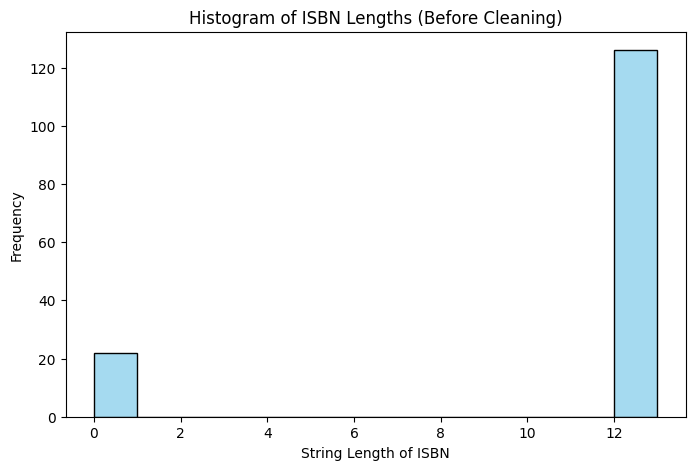

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(
    df_before['ISBN'].astype(str).str.len(),
    binwidth=1,
    kde=False,
    color='skyblue'
)
plt.title("Histogram of ISBN Lengths (Before Cleaning)")
plt.xlabel("String Length of ISBN")
plt.ylabel("Frequency")
plt.show()

*   **ISBN Length (After)**

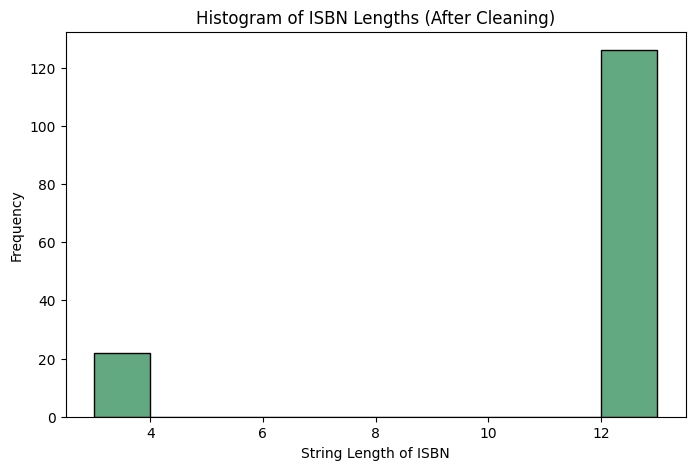

In [176]:
plt.figure(figsize=(8,5))
sns.histplot(
    df_after['ISBN'].astype(str).str.len(),
    binwidth=1,
    kde=False,
    color='seagreen'
)
plt.title("Histogram of ISBN Lengths (After Cleaning)")
plt.xlabel("String Length of ISBN")
plt.ylabel("Frequency")
plt.show()

*   **Title vs Author Lengths (Before)**

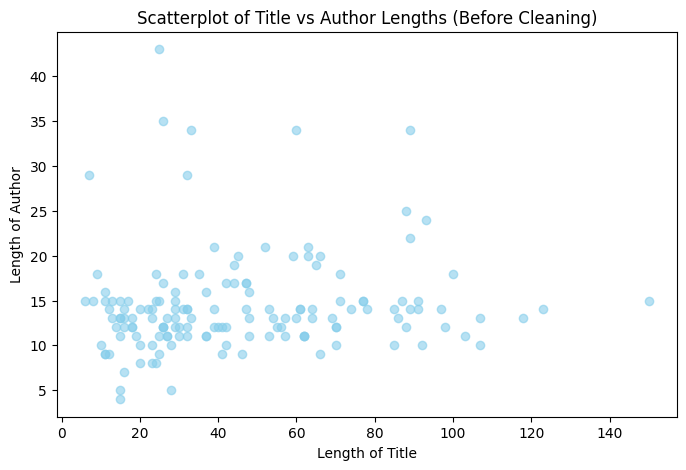

In [177]:
plt.figure(figsize=(8,5))
plt.scatter(
    df_before['Title'].astype(str).str.len(),
    df_before['Author'].astype(str).str.len(),
    color='skyblue',
    alpha=0.6
)
plt.title("Scatterplot of Title vs Author Lengths (Before Cleaning)")
plt.xlabel("Length of Title")
plt.ylabel("Length of Author")
plt.show()


*   **Title vs Author Lengths (After)**

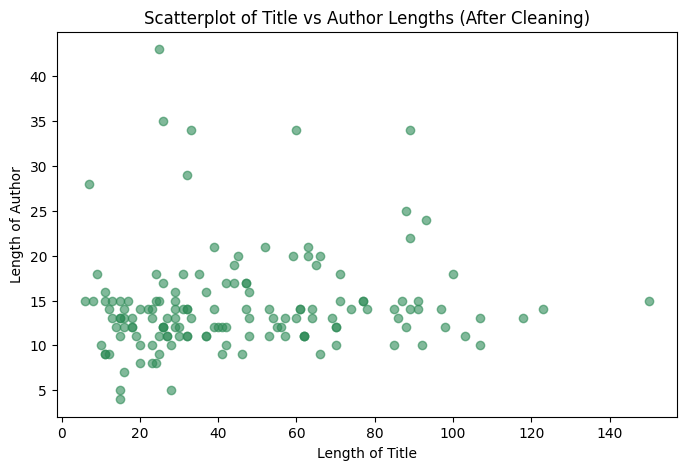

In [178]:
plt.figure(figsize=(8,5))
plt.scatter(
    df_after['Title'].str.len(),
    df_after['Author'].str.len(),
    color='seagreen',
    alpha=0.6
)
plt.title("Scatterplot of Title vs Author Lengths (After Cleaning)")
plt.xlabel("Length of Title")
plt.ylabel("Length of Author")
plt.show()

*   **Genre Count (Before)**

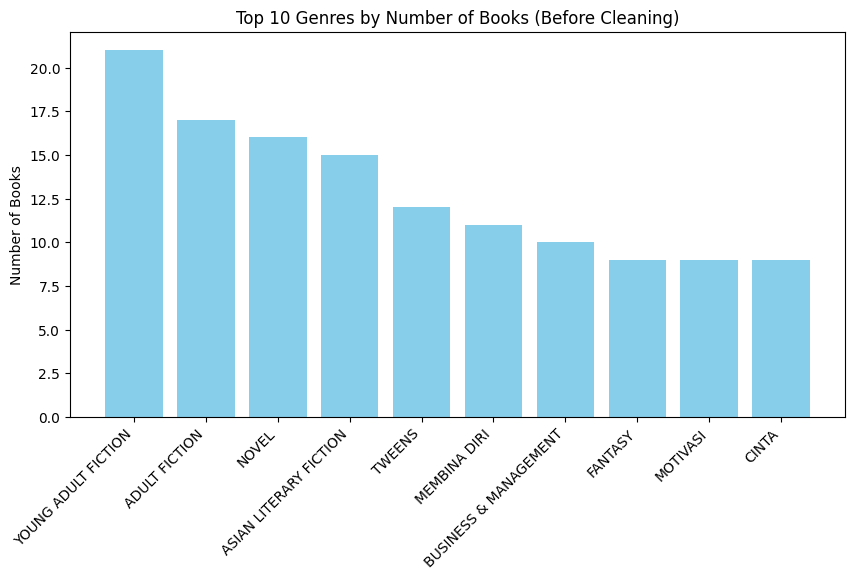

In [179]:
top_genres_before = (
    df_before['Genres']
    .astype(str)
    .str.split(',')
    .explode()
    .str.strip()
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10,5))
plt.bar(top_genres_before.index, top_genres_before.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Books")
plt.title("Top 10 Genres by Number of Books (Before Cleaning)")
plt.show()

*   **Genre Count (After)**

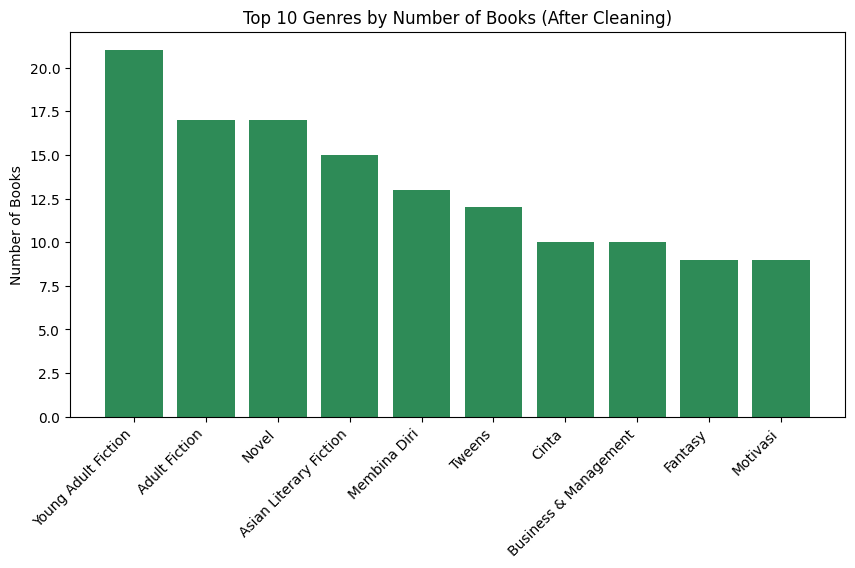

In [180]:
top_genres_after = (
    df_after['Genres']
    .astype(str)
    .str.split(',')
    .explode()
    .str.strip()
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10,5))
plt.bar(top_genres_after.index, top_genres_after.values, color='seagreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Books")
plt.title("Top 10 Genres by Number of Books (After Cleaning)")
plt.show()



*   Date Published (Before)



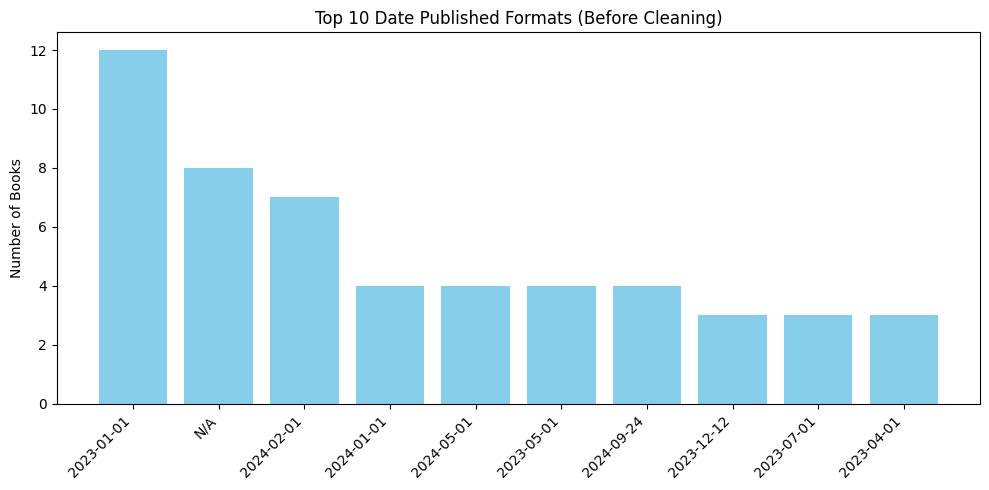

In [181]:
# BEFORE CLEANING - Shows all the messy date formats including "n/a"
date_formats_before = (
    df_before['Date Published']  # Your raw data DataFrame
    .astype(str)
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10,5))
plt.bar(date_formats_before.index, date_formats_before.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Books")
plt.title("Top 10 Date Published Formats (Before Cleaning)")
plt.tight_layout()
plt.show()


In [183]:
import numpy as np

# Step 1: Remove string missing values
missing_indicators = ['N/A', 'n/a', 'NA', 'NaN', 'nan', 'NULL', 'null', '', ' ']
df['Date Published'] = df['Date Published'].replace(missing_indicators, np.nan)

# Step 2: Convert to datetime (CRITICAL)
df['Date Published'] = pd.to_datetime(df['Date Published'], errors='coerce')

# Verify it worked
print("Column dtype:", df['Date Published'].dtype)  # Should be datetime64[ns]
print("Sample values:", df['Date Published'].head())


Column dtype: datetime64[ns]
Sample values: 0   2023-11-15
1   2025-02-01
2   2024-06-30
3   2024-08-07
4   2024-09-24
Name: Date Published, dtype: datetime64[ns]


* Date Published (After)

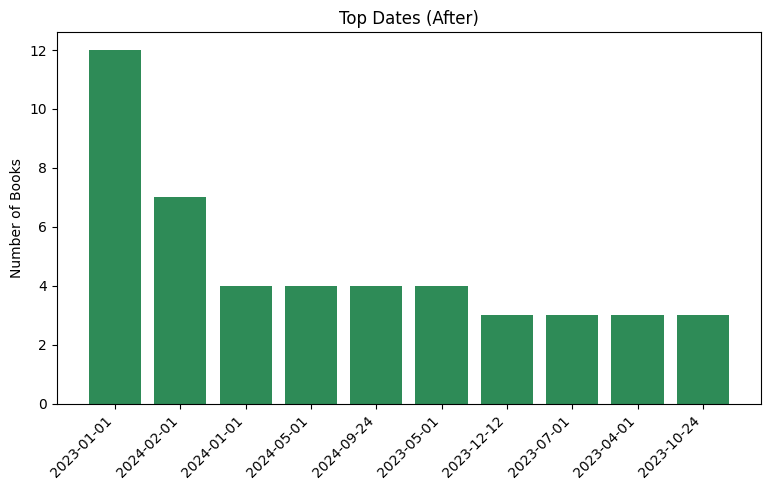

In [186]:
plt.figure(figsize=(15,5))

# Bar chart - clean dates
date_clean = df['Date Published'].dropna().dt.strftime('%Y-%m-%d').value_counts().head(10)
plt.subplot(1, 2, 1)
plt.bar(date_clean.index, date_clean.values, color='seagreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Books")
plt.title("Top Dates (After)")

plt.tight_layout()
plt.show()


* Format(before)

In [ ]:
# FORMAT - BEFORE
format_counts_before = (
    df_before['Format']
    .astype(str)
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10,5))
plt.bar(format_counts_before.index, format_counts_before.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Books")
plt.title("Top 10 Formats by Number of Books (Before Cleaning)")
plt.tight_layout()
plt.show()


* Format (After)

In [ ]:
# FORMAT - AFTER
format_counts_after = (
    df['Format']
    .astype(str)
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10,5))
plt.bar(format_counts_after.index, format_counts_after.values, color='seagreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Books")
plt.title("Top 10 Formats by Number of Books (After Cleaning)")
plt.tight_layout()
plt.show()


*c*. **PROJECT GOAL VISUALIZATION**




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned dataset
df = pd.read_csv("mph_book_cleaned.csv", dtype={'ISBN': str}, keep_default_na=False)

df.head()


**1. Which publishers (vendors) dominate the bestseller list**

In [ ]:
df['Vendor'] = df['Vendor'].str.strip().str.title()
top_vendors = df['Vendor'].value_counts().head(10)

plt.figure()
top_vendors.plot(kind='bar')
plt.title("Top 10 Publishers in MPHOnline Bestseller List")
plt.xlabel("Publisher")
plt.ylabel("Number of Bestselling Books")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


 **2.Which genres appear most frequently**

In [ ]:
# Split genres into individual rows
genres_series = df['Genres'].str.split(', ')
genres_exploded = genres_series.explode()

top_genres = genres_exploded.value_counts().head(10)

plt.figure()
top_genres.plot(kind='bar')
plt.title("Most Frequent Genres in Bestseller Books")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**3. How price varies across publications**

In [ ]:
plt.figure()
plt.boxplot(df['Price'])
plt.title("Price Distribution of Bestselling Books")
plt.ylabel("Price (RM)")
plt.show()


**4. How publication date relates to popularity**





In [ ]:
# Convert Date Published to datetime
df_date = df[df['Date Published'] != 'N/A'].copy()
df_date['Date Published'] = pd.to_datetime(df_date['Date Published'])

plt.figure()
plt.scatter(df_date['Date Published'], df_date['Best Selling Rank'])
plt.title("Publication Date vs Bestseller Rank")
plt.xlabel("Publication Date")
plt.ylabel("Best Selling Rank (Lower = More Popular)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#**LOADING CLEAN DATA (LOAD)**

In [ ]:
#Load CSV File of cleaned data.
import pandas as pd

cleaned_df = pd.read_csv("mph_book_cleaned.csv", dtype={'ISBN': str}, keep_default_na=False)
print("Cleaned data saved as mph_book_cleaned.csv.")

cleaned_df.head()